# Expedia predict destination : 
The goal of this Kaggle competition is to predit the hotel of user

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from datetime import datetime
import xgboost as xgb
%matplotlib inline 

# Explore and vizualise data : 

In [24]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv",nrows=90000)
destinations = pd.read_csv("destinations.csv")
submission = pd.read_csv("sample_submission.csv")
target = train.hotel_cluster

In [25]:
print "We have",train.shape[0], "train values and",train.shape[1],"variables and",test.shape[0],"test rows"

We have 90000 train values and 24 variables and 2528243 test rows


In [26]:
id = np.empty(2528243)
for i in range(2528243):
    id[i] = int(i)
id = np.array(id, dtype=np.int32)

In [27]:
train.orig_destination_distance.fillna(0,inplace=True)
test.orig_destination_distance.fillna(0,inplace=True)

In [28]:
hotel_nights = pd.to_datetime(train['srch_co']) - pd.to_datetime(train['srch_ci']) 
hotel_nights = (hotel_nights / np.timedelta64(1, 'D')).astype(float) # convert to float to avoid NA problems
train['hotel_nights'] = hotel_nights

#hotel_nights_test = pd.to_datetime(test['srch_co']) - pd.to_datetime(test['srch_ci']) 
#hotel_nights_test = (hotel_nights_test / np.timedelta64(1, 'D')).astype(float) # convert to float to avoid NA problems
#test['hotel_nights'] = hotel_nights_test

In [29]:
train = train.drop('date_time',1)
train = train.drop('srch_co',1)
train = train.drop('srch_ci',1)

#test = test.drop('date_time',1)
#test = test.drop('srch_co',1)
#test = test.drop('srch_ci',1)

In [30]:
train.hotel_nights.fillna(0,inplace=True)
train[train.hotel_nights <0] = 0


#test.hotel_nights.fillna(0,inplace=True)
#test[test.hotel_nights <0] = 0

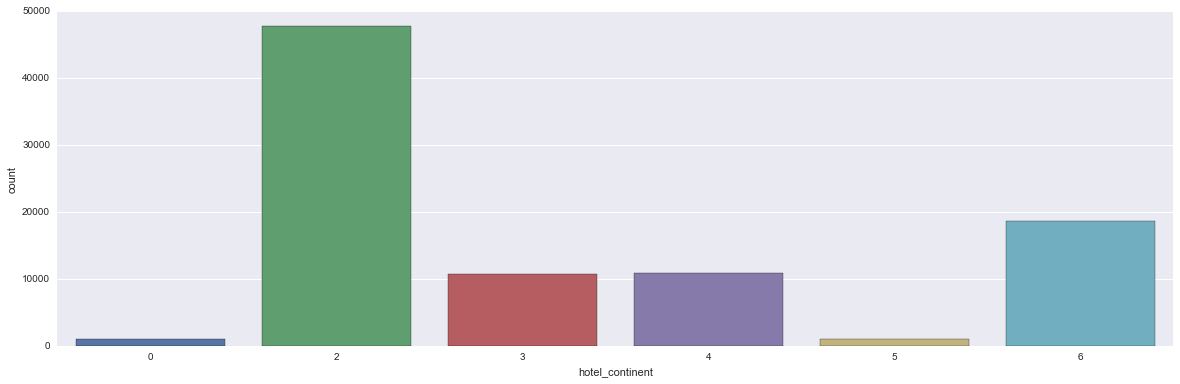

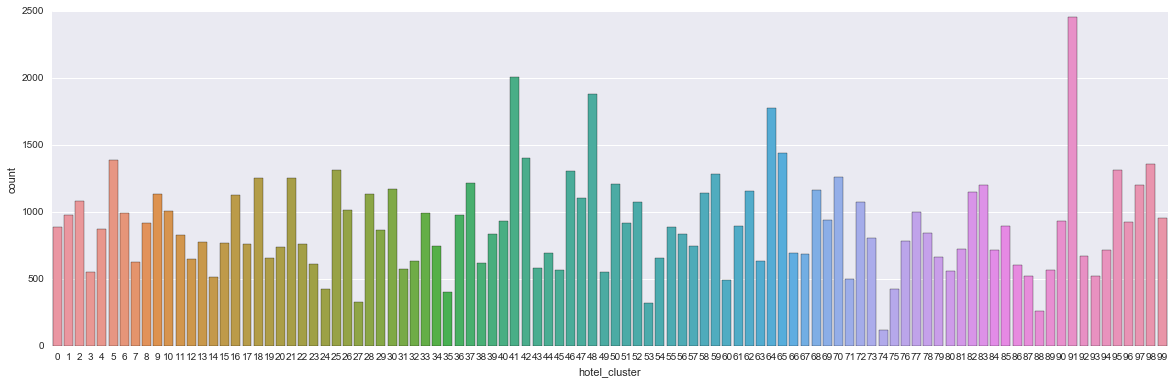

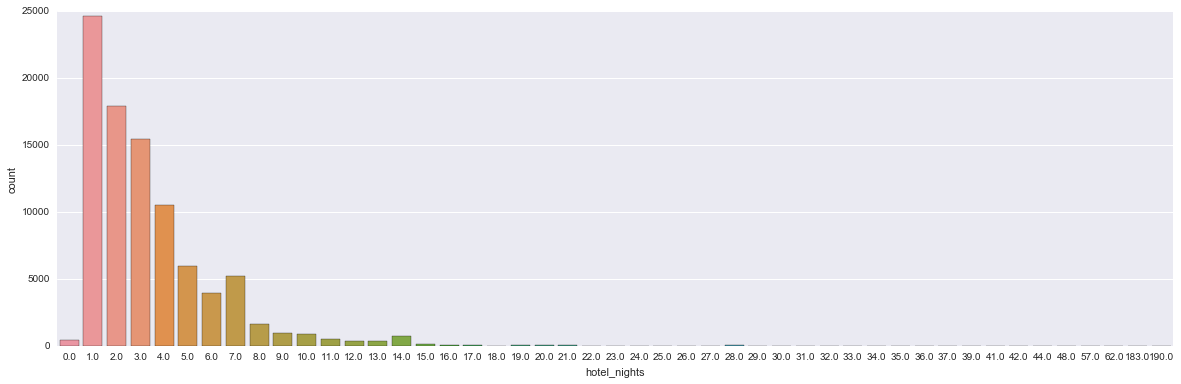

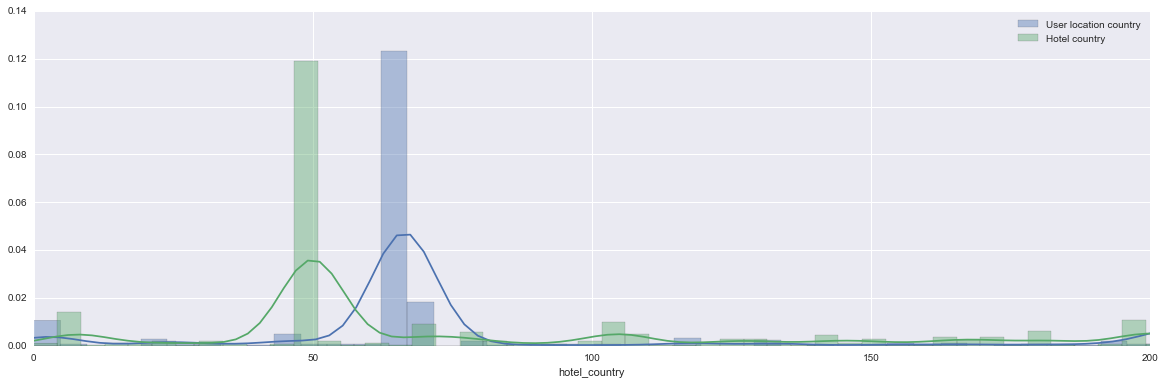

In [31]:
plt.figure(figsize=(20,6))
sns.countplot(train.hotel_continent)
plt.figure(figsize=(20,6))
sns.countplot(train.hotel_cluster)
plt.figure(figsize=(20,6))
sns.countplot(train.hotel_nights)
plt.figure(figsize=(20,6))
sns.distplot(train.user_location_country,label="User location country")
sns.distplot(train.hotel_country,label="Hotel country")
plt.xlim([0,200])
plt.legend()

We notice that most of booking is from continent 2, and the most reccurent hotel cluster is the cluster 91 and 41

In [32]:
print "The average of booking nights is : ",np.mean(train.hotel_nights)," nights by user"

The average of booking nights is :  3.39924444444  nights by user


In [33]:
columns = train.columns
for col in columns : 
    if(train[col].dtype !='object'):
        print col
        print(train[col].corr(train['hotel_cluster']))

site_name
-0.016331262939
posa_continent
-0.000586731043576
user_location_country
-0.025290379734
user_location_region
0.0091683672969
user_location_city
-0.00688258854375
orig_destination_distance
0.00477310086855
user_id
0.000326186216411
is_mobile
-0.00312898951913
is_package
0.049849872666
channel
-0.00918971743407
srch_adults_cnt
0.00728056310214
srch_children_cnt
0.00460243314172
srch_rm_cnt
-0.00439388138857
srch_destination_id
-0.00800205523856
srch_destination_type_id
-0.0301045016576
is_booking
-0.025099666836
cnt
-0.000781390942775
hotel_continent
-0.00735586779838
hotel_country
-0.0227988426757
hotel_market
0.0338226164757
hotel_cluster
1.0
hotel_nights
0.0435817065353


In [74]:
lda = LDA(n_components = 3)
X_r = lda.fit(train,target).transform(train)
pca = PCA(n_components = 2)
X_r2 = pca.fit(train).transform(train)
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [ 0.95880174  0.02861608]


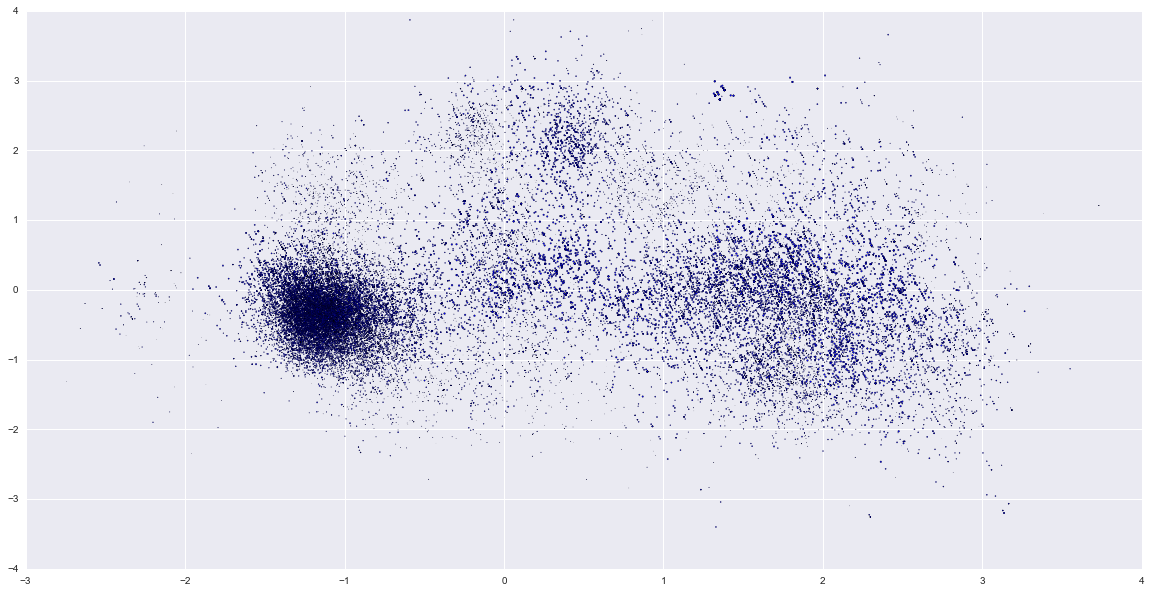

In [72]:
x = X_r[:,0]
y = X_r[:,1]
z = X_r[:,2]
plt.figure(figsize=(20,10))
plt.xlim([-3,4])
plt.ylim([-4,4])
plt.scatter(x, y, z)
plt.show()

In [36]:
train = train.drop('hotel_cluster',1)

In [37]:
'''
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=10)
model.fit(train, target)
predicts = model.predict(test)
predicts = [ ceil(x) for x in predicts ]
predicts = [ int(x) for x in predicts ]
submission = pd.DataFrame({"id":id, "hotel_cluster":predicts})
submission.to_csv("submission_rfc.csv", index=False)
rfs = pd.read_csv("submission_rfc.csv")
'''

'\nmodel = RandomForestRegressor(n_estimators=100, min_samples_leaf=10)\nmodel.fit(train, target)\npredicts = model.predict(test)\npredicts = [ ceil(x) for x in predicts ]\npredicts = [ int(x) for x in predicts ]\nsubmission = pd.DataFrame({"id":id, "hotel_cluster":predicts})\nsubmission.to_csv("submission_rfc.csv", index=False)\nrfs = pd.read_csv("submission_rfc.csv")\n'